In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-08-03 02:07:52--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 142.251.171.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M   191MB/s    in 0.3s    

2023-08-03 02:07:53 (191 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]



In [10]:
import os
import shutil

if os.path.exists('./content/cats_and_dogs_filtered/'):
    shutil.rmtree('/content/cats_and_dogs_filtered/')
    print('/content/cats_and_dogs_filtered/ is removed !!!')

In [11]:
import zipfile

with zipfile.ZipFile('/content/cats_and_dogs_filtered.zip', 'r') as target_file:
    target_file.extractall('/content/cats_and_dogs_filtered/')

In [13]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0,25))

# 정답은 'cat', 'dog' 2개이므로 출력층 노드는 2개
model.add(Dense(2, activation='softmax'))

model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 16)                32784     
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 20,894,298
Trainable params: 20,839,770
N

In [14]:
train_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/train'
test_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

train_data_gen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=10, width_shift_range=0.1,
                                    height_shift_range=0.1, shear_range=0.1, zoom_range=0.1)

test_data_gen = ImageDataGenerator(rescale=1./255)

In [18]:
# class_mode가 categorical 이므로 정답은 one-hot encoding 정의
train_data = train_data_gen.flow_from_directory(train_dir, batch_size=32,
                                                color_mode='rgb', shuffle=True, class_mode='categorical',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT))

test_data = test_data_gen.flow_from_directory(test_dir, batch_size=32,
                                              color_mode='rgb', shuffle=True, class_mode='categorical',
                                              target_size=(IMG_WIDTH, IMG_HEIGHT))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [19]:
# 정답 확인

# class_indices 속성을 이용하면, 문자열로 표시되는 데이터의
# 정답이 어떤 숫자로 매칭되어 있는지 확인할 수 있음
print(train_data.class_indices.items())
print(test_data.class_indices.items())

dict_items([('cats', 0), ('dogs', 1)])
dict_items([('cats', 0), ('dogs', 1)])


In [20]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

save_file_name = './cats_and_dogs_filtered_Xception_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name, monitor='val_loss',
                             verbose=1, save_best_only=True, mode='auto')

# earlystopping 조건으로 인해, overfitting이 심하게 발생하는 것을 방지
earlystopping = EarlyStopping(monitor='val_loss', patience=5)

hist = model.fit(train_data, epochs=30, validation_data=test_data, callbacks=[checkpoint, earlystopping])

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.4819 - accuracy: 0.8615
Epoch 1: val_loss improved from inf to 0.13712, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 119s 917ms/step - loss: 0.4819 - accuracy: 0.8615 - val_loss: 0.1371 - val_accuracy: 0.9810
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.1835 - accuracy: 0.9725
Epoch 2: val_loss improved from 0.13712 to 0.05237, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 47s 735ms/step - loss: 0.1835 - accuracy: 0.9725 - val_loss: 0.0524 - val_accuracy: 0.9860
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.0926 - accuracy: 0.9795
Epoch 3: val_loss improved from 0.05237 to 0.04244, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 42s 665ms/step - loss: 0.0926 - accuracy: 0.9795 - val_loss: 0.0424 - val_accuracy:

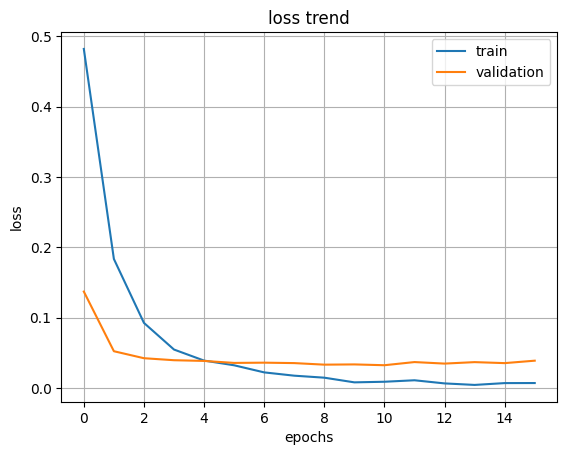

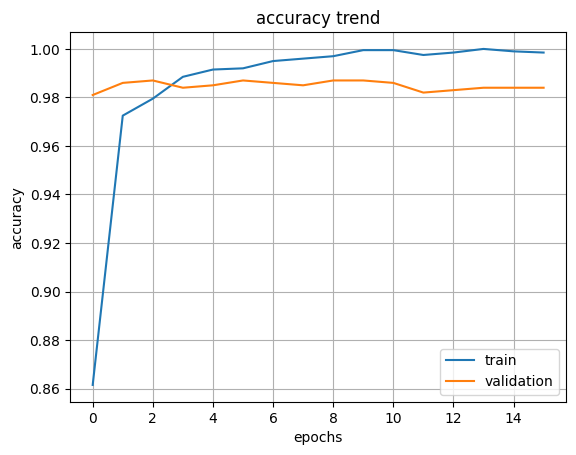

In [23]:
import matplotlib.pyplot as plt

plt.title('loss trend')
plt.grid()

plt.xlabel('epochs')
plt.ylabel('loss')

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')

plt.legend(loc='best')
plt.show()


plt.title('accuracy trend')
plt.grid()

plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')

plt.legend(loc='best')
plt.show()

In [24]:
import os
import shutil

if os.path.exists('/content/test_image_dir/'):
    shutil.rmtree('/content/test_image_dir/')
    print('/content/test_image_dir/ is removed !!!')

In [25]:
import zipfile

with zipfile.ZipFile('/content/test_image_dir.zip', 'r') as target_file:
  target_file.extractall('/content/test_image_dir/')

In [30]:
import cv2
import glob

test_img_list = []
# 테스트 이미지 파일이름 리스트
test_img_name_list = glob.glob('test_image_dir/test_image_dir/*')

for i in range(len(test_img_name_list)):
  # 테스트 이미지 파일 로드 및 전처리
  src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
  src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))

  dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
  dst_img = dst_img / 255.0

  test_img_list.append(dst_img)

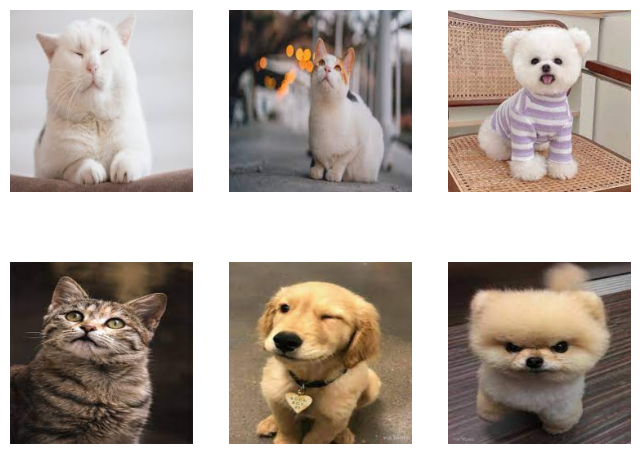

In [31]:
plt.figure(figsize=(8,6))

for i in range(len(test_img_list)):
    plt.subplot(2, 3, i+1) # 2행 3열
    plt.axis('off')
    plt.imshow(test_img_list[i])

plt.show()

In [32]:
for i in range(len(test_img_list)):
  print(test_img_list[i].shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


1/1 [==============================] - 0s 37ms/step


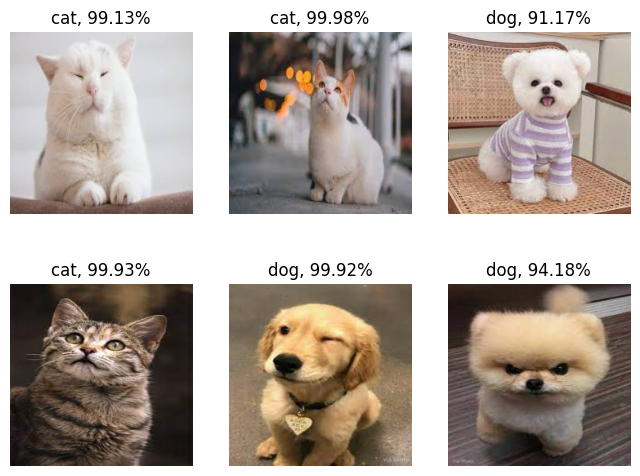

In [34]:
import numpy as np

# batch 차원을 추가하여 predict 실행 (batch_size, width, height, channel)
pred = model.predict(np.array(test_img_list))

class_name = ['cat', 'dog'] # ImageDataGenerator 에서 cat = 0, dog = 1

plt.figure(figsize=(8,6))

for i in range(len(pred)):
  plt.subplot(2, 3, i+1)
  prediction = str(class_name[np.argmax(pred[i])])
  probility = '{0:0.2f}'.format(100*max(pred[i]))
  title_str = prediction + ', ' + probility + '%'
  plt.axis('off')
  plt.title(title_str)
  plt.imshow(test_img_list[i])

plt.show()